In [1]:
# Dataset from: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database?

# Import Libraries

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from random import shuffle
import random
import os

Using TensorFlow backend.
c:\python36_64\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36_64\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36_64\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36_64\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) o

# Define Constants

In [3]:
path = 'C:\\Users\\faiza\\COVID-19 Deep Learning\\'

IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Prepare Training Data

In [4]:
directories = ['train']
imageData = []
categories = []
    
files = os.listdir(path + directories[0])

for img in files:

    fileName = img.split('.')[0]
    
    if 'NORMAL' in fileName:
        imageData.append([fileName, 0])
        categories.append(0)

    elif 'COVID-19' in fileName:
        imageData.append([fileName, 1])
        categories.append(1)

    else:
        imageData.append([fileName, 2])
        categories.append(2)


fileNames = os.listdir(path + directories[0])

df = pd.DataFrame({
    'filename': fileNames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,COVID-19 (1).png,1
1,COVID-19 (10).png,1
2,COVID-19 (100).png,1
3,COVID-19 (101).png,1
4,COVID-19 (102).png,1


In [6]:
df.tail()

,filename,category
695,Viral Pneumonia (95).png,2
696,Viral Pneumonia (96).png,2
697,Viral Pneumonia (97).png,2
698,Viral Pneumonia (98).png,2
699,Viral Pneumonia (99).png,2


# Compare Frequencies 

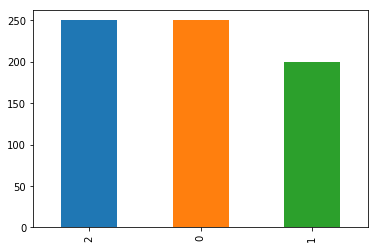

In [7]:
'''
0 Represents Normal 
1 Represents COVID-19
2 Represents Viral Pneumonia 
'''
df['category'].value_counts().plot.bar()

# Load Random Image

COVID-19 (96).png


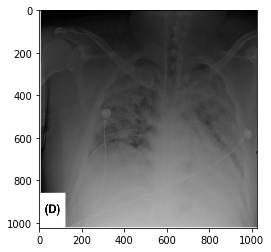

In [8]:
sample = random.choice(os.listdir(path + directories[0]))
image = load_img(path + '\\train\\' + sample)

print(sample)
plt.imshow(image)

# Build Model

1. **Input Layer**: This represents our input image data. It will reshape the image into a single dimensional array. For example, if your image is 64x64, it will convert to (4096,1) array (64x64 = 4096).


2. **Conv Layer**: This layer will extract features from image.


3. **Pooling Layer**: This layer will reduce the spatial volume of input image after convolution.


4. **Fully Connected Layer**: This will connect the network from a layer to another layer


5. **Output Layer**: This is the predicted values layer.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)      

# Callbacks

## Early Stop

To prevent overfitting, we will stop the learning after 10 epochs and if the val_loss value has not decreased

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

# Learning Rate Reduction

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [12]:
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'}) 

# Shuffle Data

In [13]:
df = df.sample(frac=1).reset_index(drop=True)
df

,filename,category
0,Viral Pneumonia (34).png,Viral Pneumonia
1,NORMAL (222).png,Normal
2,COVID-19 (80).png,COVID-19
3,Viral Pneumonia (93).png,Viral Pneumonia
4,Viral Pneumonia (119).png,Viral Pneumonia
5,Viral Pneumonia (104).png,Viral Pneumonia
6,Viral Pneumonia (69).png,Viral Pneumonia
7,COVID-19 (131).png,COVID-19
8,COVID-19 (151).jpg,COVID-19
9,COVID-19 (137).jpg,COVID-19


In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

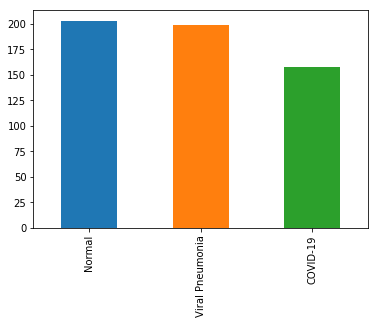

In [15]:
train_df['category'].value_counts().plot.bar()

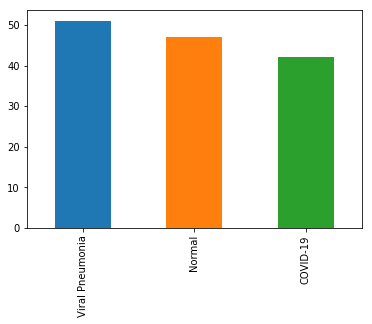

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 10

# Training Generator

In [18]:
train_datagen = ImageDataGenerator (
    
    rotation_range = 15,
    rescale = 1./255,
    
    shear_range = 0.1,
    zoom_range = 0.2,
    
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe (
    
    train_df, 
    path + '\\train', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 560 validated image filenames belonging to 3 classes.


# Validation Generator

In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe (
    
    validate_df, 
    path + '\\train', 
    x_col ='filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 140 validated image filenames belonging to 3 classes.


# Visualize Generator 

In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe (
    
    example_df, 
    path + '\\train', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


                    filename         category
0  Viral Pneumonia (107).png  Viral Pneumonia


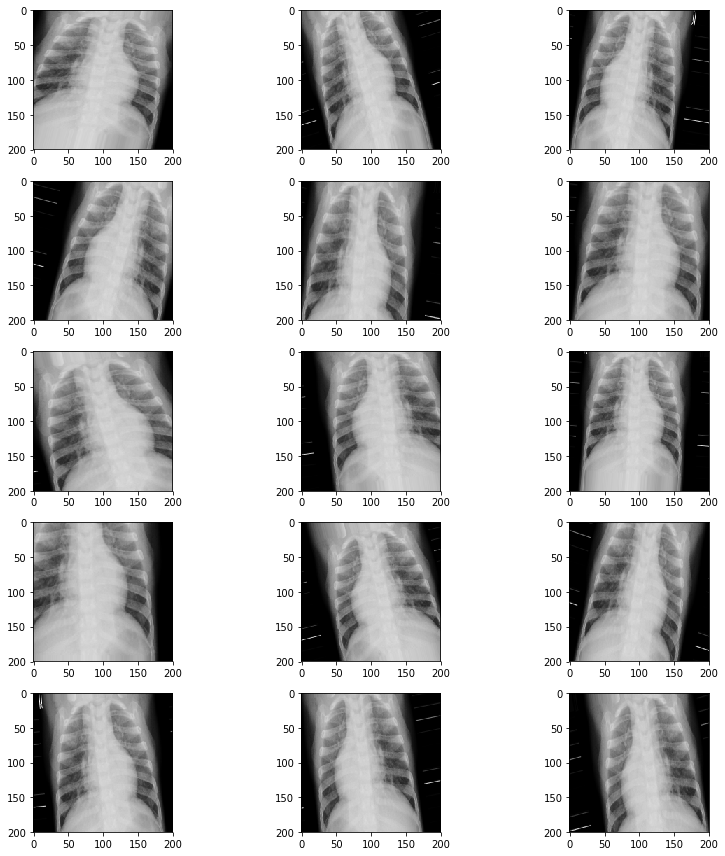

In [21]:
print(example_df)

plt.figure(figsize=(12, 12))

for i in range(0, 15):
    
    plt.subplot(5, 3, i+1)
    
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
        
plt.tight_layout()
plt.show()

In [22]:
epochs = 25

history = model.fit_generator (
    
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)


Epoch 1/25
56/56 [==============================] - 99s 2s/step - loss: 1.1499 - accuracy: 0.6643 - val_loss: 3.0230 - val_accuracy: 0.3000
Epoch 2/25
56/56 [==============================] - 95s 2s/step - loss: 0.8403 - accuracy: 0.7375 - val_loss: 9.2034 - val_accuracy: 0.3000
Epoch 3/25
56/56 [==============================] - 95s 2s/step - loss: 0.7260 - accuracy: 0.7821 - val_loss: 5.0088 - val_accuracy: 0.3714
Epoch 4/25
56/56 [==============================] - 95s 2s/step - loss: 0.6269 - accuracy: 0.7929 - val_loss: 2.0849 - val_accuracy: 0.3571
Epoch 5/25
56/56 [==============================] - 96s 2s/step - loss: 0.6751 - accuracy: 0.7875 - val_loss: 1.8273 - val_accuracy: 0.3643

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/25
56/56 [==============================] - 95s 2s/step - loss: 0.4528 - accuracy: 0.8571 - val_loss: 1.7232 - val_accuracy: 0.5000
Epoch 7/25
56/56 [==============================] - 96s 2s/step - loss: 0.5255

In [23]:
model.save_weights("COVID-Model-{}-{}-{}-{}.h5".format(IMAGE_WIDTH, 3, batch_size, epochs))

# Visualize Training Performance 

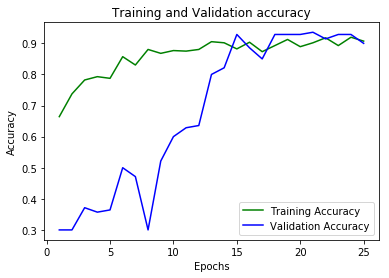

In [51]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1,  epochs + 1)
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

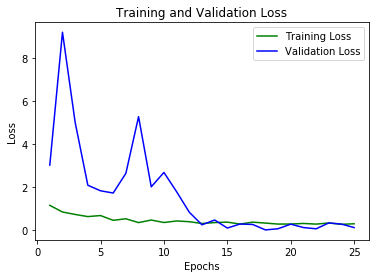

In [54]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, epochs + 1)
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prepare Testing Data

In [25]:
test_filenames = os.listdir(path + 'test')

test_df = pd.DataFrame({
    'filename': test_filenames
})

nb_samples = test_df.shape[0]

In [26]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename
0,NORMAL (440).png
1,Viral Pneumonia (604).png
2,COVID-19 (219).jpg
3,NORMAL (583).png
4,Viral Pneumonia (384).png
5,COVID-19 (233).jpg
6,Viral Pneumonia (546).png
7,NORMAL (620).png
8,NORMAL (627).png
9,Viral Pneumonia (478).png


# Create Testing Generator

In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    
    test_df, 
    path + '\\test', 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 689 validated image filenames.


# Form Predictions

In [28]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

## Pick the category that has the highest probability 

In [29]:
test_df['category'] = np.argmax(predict, axis=-1)

In [30]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [31]:
test_df['category'] = test_df['category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

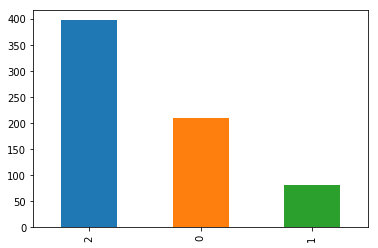

In [32]:
test_df['category'].value_counts().plot.bar()

# Predicted result with images

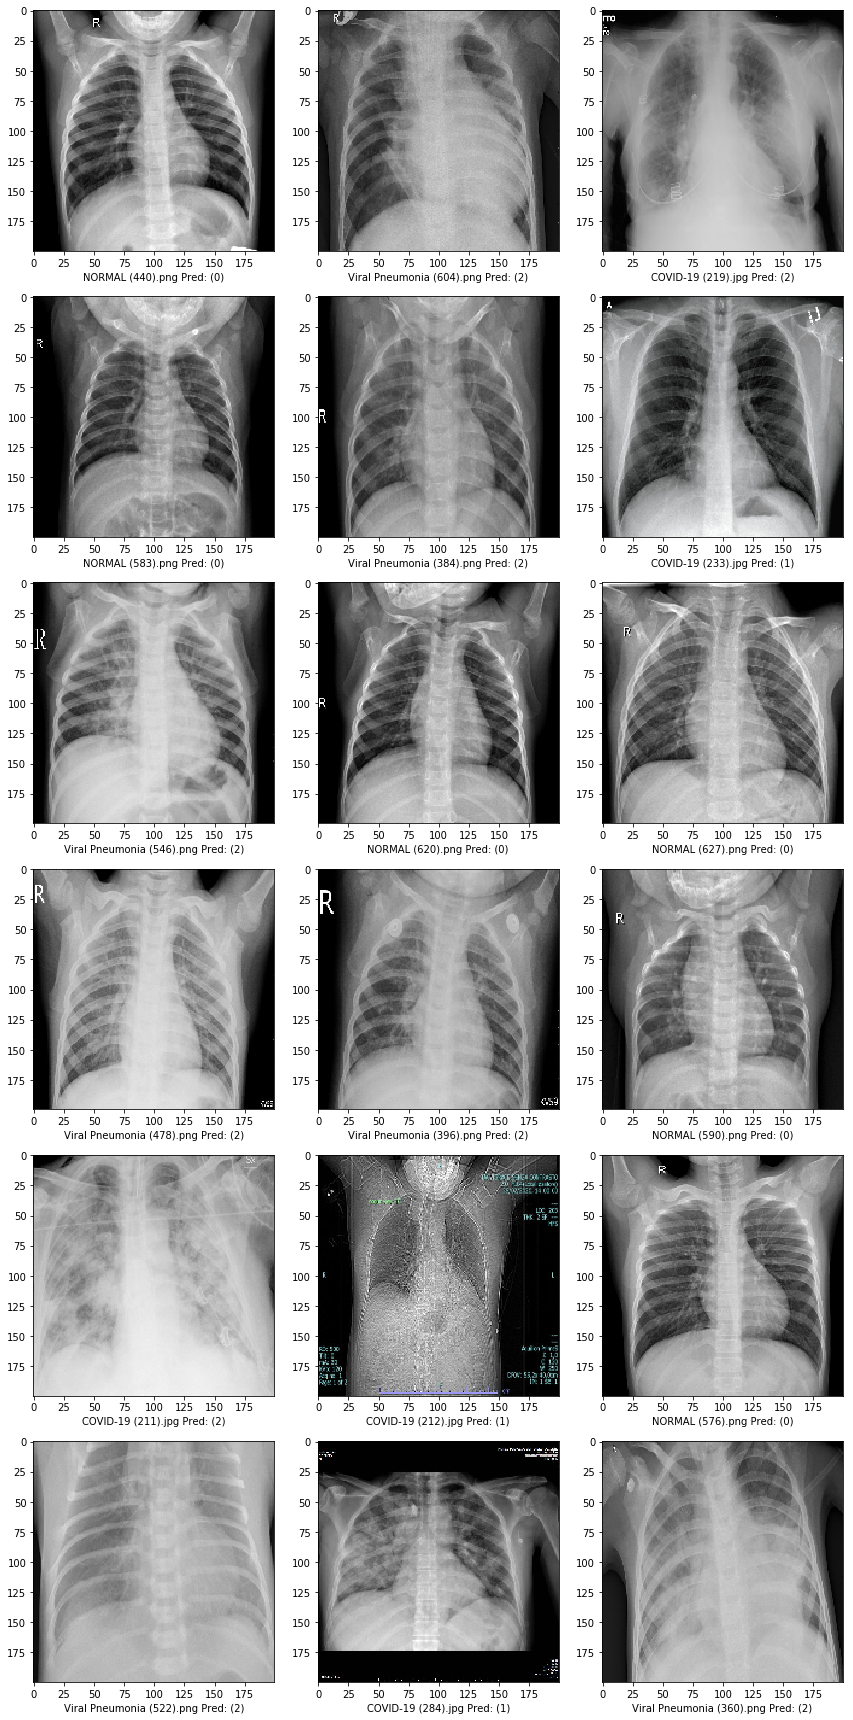

In [33]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    category = row['category']
    
    img = load_img(path + 'test\\' + filename, target_size=IMAGE_SIZE)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' Pred: (' + "{}".format(category) + ')' )
    
plt.tight_layout()
plt.show()

# Calculate Model Accuracy

In [34]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['category']
    
    img = load_img(path + 'test\\' + filename, target_size=IMAGE_SIZE)
    
    if 'NORMAL' in filename:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID-19' in filename:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in filename:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [35]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 83.31%
Correct Predictions: 574 Total Predictions: 689

Normal Predictions: 206 Accuracy 68.67%
COVID-19 Predictions: 76 Accuracy 85.39%
Viral Pneumonia Predictions: 292 Accuracy 97.33%


In [36]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    
    if 'NORMAL' in filename: actual.append(0)
    if 'COVID-19' in filename: actual.append(1)
    if 'Viral Pneumonia' in filename: actual.append(2)
        
    pred.append(row[1][1])

In [37]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       300
           1       0.93      0.85      0.89        89
           2       0.74      0.97      0.84       300

   micro avg       0.83      0.83      0.83       689
   macro avg       0.88      0.84      0.84       689
weighted avg       0.87      0.83      0.83       689



In [38]:
confusion_matrix(actual, pred)

array([[206,   2,  92],
       [  0,  76,  13],
       [  4,   4, 292]], dtype=int64)